# 히스토그램 평활화 :: 레포트 및 코랩 기반 실습

먼저 실습에 사용될 $8 \times 8$ 영상(8명암 단계)를 선언하였다.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
MAX_INTENSITY = 8

src = np.array([
    [3,2,2,2,2,3,3,4,],
    [3,2,2,2,3,4,3,3,],
    [4,3,3,4,4,4,3,3,],
    [5,4,4,4,5,4,3,3,],
    [5,4,3,4,5,4,3,2,],
    [6,5,4,4,5,4,3,2,],
    [6,6,5,5,4,3,2,2,],
    [6,5,4,5,4,3,2,2,],
], dtype=np.uint8)

위 영상으로 부터 히스토그램 평활화에 필요한 정보를 정리하면 다음 표와 같다.

| Gray level | Count | 누적 합 | 정규화 누적합 | Round Value |
| ---------- | ----- | ------- | ------------- | ----------- |
| 2          | 13    | 13      | 1.21875       | 1           |
| 3          | 18    | 31      | 2.90625       | 3           |
| 4          | 19    | 50      | 4.6875        | 5           |
| 5          | 10    | 60      | 5.625         | 6           |
| 6          | 4     | 64      | 6             | 6           |

-   $I_{max}$: 가장 높은 픽셀 값
-   Count: $H_i$. 즉, $i$ gray level을 갖는 픽셀의 개수 (히스토그램)
-   누적 합: $\sum_{k=0}^i H_k$
-   정규화 누적합: $\frac{I_{max}}{Cnt} \sum_{k=0}^i H_k$

---

아래의 단계에서는 이를 Python 코드로 구현할 것이다.


# 히스토그램 $H$ 계산

모든 픽셀을 순회하며, 각 밝기 값을 갖는 픽셀의 수를 나타내는 히스토그램 `H`를 작성한다.

[ 0  0 13 18 19 10  4  0]


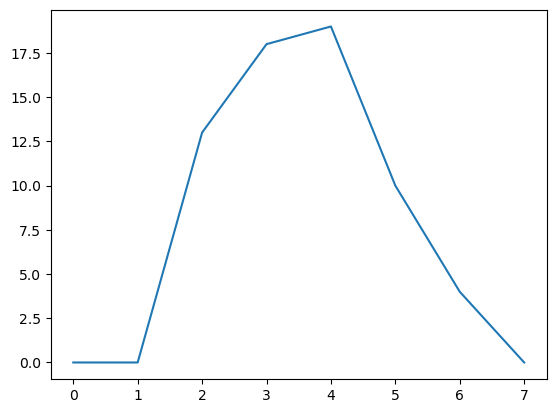

In [3]:
H = np.zeros((MAX_INTENSITY,), dtype=np.uint32)

for intensity in src.flatten():
    H[intensity] += 1

print(H)

plt.plot(H)
plt.show()

# 히스토그램 누적 합 $Acc$ 계산

앞서 구한 히스토그램 `H`를 바탕으로, 누적합인 `Acc`를 구한다.

$Acc_i = H_i + Acc_{i-1}$의 점화식을 이용하였다.

[ 0  0 13 31 50 60 64 64]


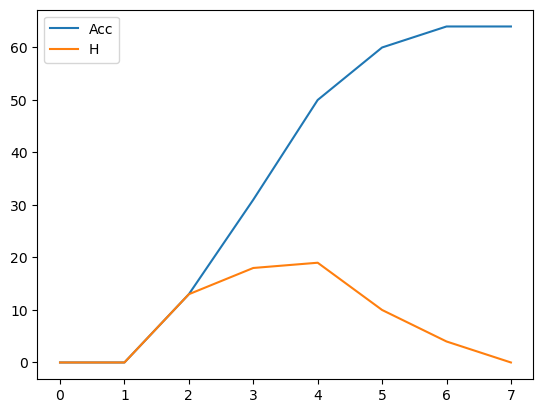

In [4]:
Acc = np.zeros((MAX_INTENSITY,), dtype=np.uint32)

for intensity in range(MAX_INTENSITY):
    Acc[intensity] = H[intensity]
    
    if intensity > 0:
        Acc[intensity] += Acc[intensity-1]

print(Acc)

plt.plot(Acc, label='Acc')
plt.plot(H, label='H')
plt.legend()

plt.show()

# 최대 밝기 값 $I_{max}$ 구하기

히스토그램에서 밝기 값을 내림차순으로 조회하며, 하나 이상의 픽셀이 존재하는 가장 먼저 나오는 밝기 값을 찾는다. 이 값이 $I_{max}$가 된다.

In [5]:
I_max = 0

for intensity in reversed(range(MAX_INTENSITY)):
    if H[intensity] > 0:
        I_max = intensity
        break

print(I_max)

6


# 모든 픽셀의 개수 $Count$ 구하기

numpy의 `ndarray` 자료형에서 제공하는 `size` 속성을 활용하여 모든 픽셀의 개수를 구하였다.

In [6]:
count = src.size

print(count)

64


# 정규화 누적합 구하기

다음의 수식을 이용하여 정규화 누적합을 구해 `normalizedValues` 변수에 저장한다.

$$
\frac{I_{max}}{sum} \times \text{누적합}
$$

In [7]:
normalizedValues = np.zeros((MAX_INTENSITY,), dtype=np.double)

for intensity in range(MAX_INTENSITY):
    normalizedValues[intensity] = I_max / count * Acc[intensity]

print(normalizedValues)

[0.      0.      1.21875 2.90625 4.6875  5.625   6.      6.     ]


# Round Value 구하기

In [8]:
roundValues = []
for normalizedVal in normalizedValues:
    roundValues.append(round(normalizedVal))

print(roundValues)

[0, 0, 1, 3, 5, 6, 6, 6]


# 히스토그램 평활화 하기

앞서 구한 정규화 누적합의 반올림 값을 이용하여, 각 밝기 값에 분포한 픽셀들을 다른 값으로 이동시키므로서 히스토그램 평활화를 수행한다.

In [9]:
dst = np.zeros_like(src)

h, w = src.shape

for y in range(h):
    for x in range(w):
        dst[y,x] = roundValues[src[y][x]]

print('평활화 전:\n', src)
print('평활화 후:\n', dst)

평활화 전:
 [[3 2 2 2 2 3 3 4]
 [3 2 2 2 3 4 3 3]
 [4 3 3 4 4 4 3 3]
 [5 4 4 4 5 4 3 3]
 [5 4 3 4 5 4 3 2]
 [6 5 4 4 5 4 3 2]
 [6 6 5 5 4 3 2 2]
 [6 5 4 5 4 3 2 2]]
평활화 후:
 [[3 1 1 1 1 3 3 5]
 [3 1 1 1 3 5 3 3]
 [5 3 3 5 5 5 3 3]
 [6 5 5 5 6 5 3 3]
 [6 5 3 5 6 5 3 1]
 [6 6 5 5 6 5 3 1]
 [6 6 6 6 5 3 1 1]
 [6 6 5 6 5 3 1 1]]


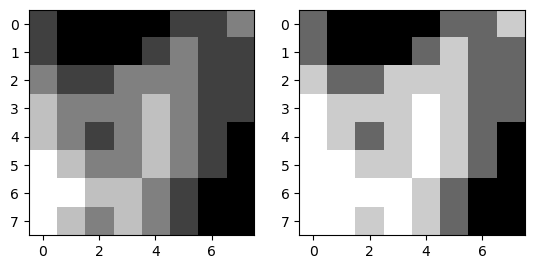

In [10]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(src, cmap='gray')
axs[1].imshow(dst, cmap='gray')